In [1]:
# import all necessary libraries
import os
os.chdir('..')

import functions
from functions import mask_data_modis

import geopandas as gpd
import xarray

import numpy as np
import scipy.io as sio

import pandas as pd
from datetime import datetime
from datetime import timedelta

import cftime

import matplotlib.pyplot as plt

In [2]:
# open data
#MODIS_path = 'MODIS_ET/Geographic Projection/MOD16A2GF/MOD16A2GF.061_500m_aid0001.nc'
MODIS_path = 'MODIS_ET/MOD16A2GF_Terra/MOD16A2GF.061_500m_aid0001.nc'
#MODIS_path = 'MODIS_ET/MODIS_ET_GF/TERRA/MOD16A2GF.061_500m_aid0001.nc'

In [3]:
modis_data = xarray.open_dataset(MODIS_path, chunks={'time': 1})

/Users/natashamarsden/miniconda3/envs/spanalytics/lib/python3.11/site-packages/xarray/core/dataset.py:277: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


In [4]:
modis_data = modis_data.where(modis_data.ET_500m <= 3276)
modis_data = modis_data.where(modis_data.ET_500m >= -3276)

In [5]:
modis_data['time'] = pd.to_datetime(modis_data.indexes['time'].to_datetimeindex())

/var/folders/gb/ql94hjx53l9_bb657yf5p0880000gn/T/ipykernel_4765/1076264592.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  modis_data['time'] = pd.to_datetime(modis_data.indexes['time'].to_datetimeindex())


In [6]:
modis_data = modis_data.rename({'lat': 'latitude'})
modis_data = modis_data.rename({'lon': 'longitude'})

In [7]:
modis_et = modis_data.ET_500m

In [8]:
# import MDB regions from subfolder
MDB_northeast_shape = gpd.read_file('MDB_Regions/MDB_Northeast_Region.shp')
MDB_northwest_shape = gpd.read_file('MDB_Regions/MDB_Northwest_Region.shp')
MDB_southeast_shape = gpd.read_file('MDB_Regions/MDB_Southeast_Region.shp')
MDB_southwest_shape = gpd.read_file('MDB_Regions/MDB_Southwest_Region.shp')

In [9]:
ne_et = mask_data_modis(data = modis_et, boundary = MDB_northeast_shape)
nw_et = mask_data_modis(data = modis_et, boundary = MDB_northwest_shape)
se_et = mask_data_modis(data = modis_et, boundary = MDB_southeast_shape)
sw_et = mask_data_modis(data = modis_et, boundary = MDB_southwest_shape)

## NORTHEAST BASIN

In [10]:
ne_et.shape

(1024, 2172, 1618)

In [11]:
r = 6371000  # earth radius in m

In [12]:
# degree intervals
delta_lat = np.abs(np.diff(ne_et.latitude.values).mean())
delta_lon = np.abs(np.diff(ne_et.longitude.values).mean())

# latitude values
latitudes = ne_et.latitude.values
colatitudes = 90 - latitudes  # Convert to colatitude

# convert to radians
dphi = np.deg2rad(delta_lon)
dtheta = np.deg2rad(delta_lat)
colat_rad = np.deg2rad(colatitudes)

# compute area weights for each latitude
area_weights_1d = (r**2) * np.sin(colat_rad) * dtheta * dphi  # shape: (lat,)
area_weights_2d = np.tile(area_weights_1d[:, np.newaxis], (1, ne_et.longitude.size))

# convert to xarray
ne_area_weights = xarray.DataArray(
    area_weights_2d,
    coords={"latitude": ne_et.latitude, "longitude": ne_et.longitude},
    dims=["latitude", "longitude"]
)

In [13]:
ne_area_weights.shape

(2172, 1618)

In [14]:
len_time = ne_et.shape[0]
ne_et_mean = np.zeros([len_time , 1])

for ii in range(len_time):
    
    aa = ne_et[ii,:,:];
    if np.mod(ii , 50) == 0:
        print(str(ii)+'/'+str(len_time)+'...')
        
    masked_weights = ne_area_weights.where(~np.isnan(aa))
    normalized_weights = masked_weights / masked_weights.sum(skipna=True)
    ne_et_mean[ii] = (aa * normalized_weights).sum(skipna=True).values

0/1024...
50/1024...
100/1024...
150/1024...
200/1024...
250/1024...
300/1024...
350/1024...
400/1024...
450/1024...
500/1024...
550/1024...
600/1024...
650/1024...
700/1024...
750/1024...
800/1024...
850/1024...
900/1024...
950/1024...
1000/1024...


In [15]:
# divide by 8 to get daily values
ne_et_mean = ne_et_mean/8

In [16]:
modis_times = ne_et.time.values

In [17]:
# define daily times
daily_timesteps = np.arange('2002-02-19', '2024-05-25', dtype='datetime64[D]')

In [18]:
# define empty xarray
ne_et_daily_mean = np.full(len(daily_timesteps ), np.nan)

In [19]:
for i in range(len(ne_et_mean)):
    
    # get corresponding date
    modis_date = modis_times[i]

    # get the MODIS value for that date
    value = ne_et_mean[i]
    
    # define the 8-day window ending at modis_date (i.e., modis_date - 7 days to modis_date)
    daily_dates = pd.date_range(modis_date - pd.Timedelta(days=7), modis_date, freq='D')
    
    # For each date in this 8-day window, assign the MODIS value (if date is in target range)
    for day in daily_dates:

        # Find index of this day in daily_dates
        idx = np.where(daily_timesteps == np.datetime64(day))[0]

        if idx.size > 0:
            ne_et_daily_mean[idx[0]] = value

In [20]:
ne_et_daily_mean[0:30]

array([1.15714204, 1.15714204, 1.15714204, 1.15714204, 1.15714204,
       1.15714204, 1.15714204, 1.15714204, 0.94192194, 0.94192194,
       0.94192194, 0.94192194, 0.94192194, 0.94192194, 0.94192194,
       0.94192194, 0.52037688, 0.52037688, 0.52037688, 0.52037688,
       0.52037688, 0.52037688, 0.52037688, 0.52037688, 0.76056672,
       0.76056672, 0.76056672, 0.76056672, 0.76056672, 0.76056672])

In [21]:
# create xarray
ne_et_daily_mean = xarray.DataArray(
    ne_et_daily_mean,
    coords={'time': daily_timesteps},
    dims='time',
    name='ne_et_daily_mean'
)

/var/folders/gb/ql94hjx53l9_bb657yf5p0880000gn/T/ipykernel_4765/3950546293.py:2: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ne_et_daily_mean = xarray.DataArray(


In [22]:
# define dates in pd datetime format
dates = pd.to_datetime(daily_timesteps)

# build a list of "15th of month" dates from the range
mid_months = [t for t in dates if t.day == 15]

monthly_chunks = []

for mid_month in mid_months:

    # Define start as the 16th of previous month
    if mid_month.month == 1:
        start_month = 12
        start_year = mid_month.year - 1
    else:
        start_month = mid_month.month - 1
        start_year = mid_month.year

    period_start = datetime(start_year, start_month, 16)
    period_end = mid_month

    # Slice ET data for that time range
    daily_et_in_month = ne_et_daily_mean.sel(time=slice(period_start, period_end))

    if daily_et_in_month.time.size > 0:
        total_et = daily_et_in_month.sum(dim='time', skipna=True)
        total_et = total_et.expand_dims(time=[mid_month])
        monthly_chunks.append(total_et)

# Combine into one DataArray
ne_monthly_et = xarray.concat(monthly_chunks, dim='time')

In [23]:
ne_monthly_et.shape

(267,)

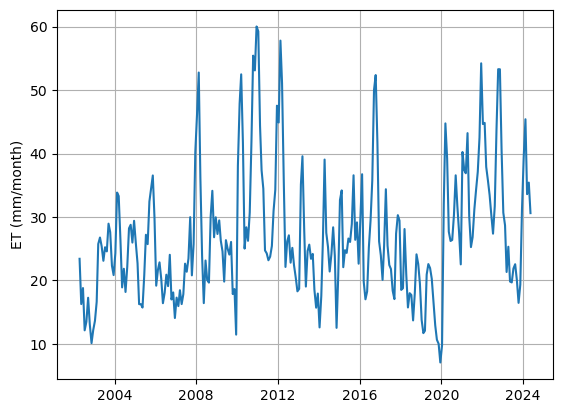

In [24]:
plt.plot(mid_months[1:], ne_monthly_et[1:])
plt.ylabel('ET (mm/month)')
plt.grid()
plt.imshow;

In [25]:
np.save('MODIS_ET/ne_modis_et_mean', ne_monthly_et)

## NORTHWEST BASIN

In [26]:
# degree intervals
delta_lat = np.abs(np.diff(nw_et.latitude.values).mean())
delta_lon = np.abs(np.diff(nw_et.longitude.values).mean())

# latitude values
latitudes = nw_et.latitude.values
colatitudes = 90 - latitudes  # Convert to colatitude

# convert to radians
dphi = np.deg2rad(delta_lon)
dtheta = np.deg2rad(delta_lat)
colat_rad = np.deg2rad(colatitudes)

# compute area weights for each latitude
area_weights_1d = (r**2) * np.sin(colat_rad) * dtheta * dphi  # shape: (lat,)
area_weights_2d = np.tile(area_weights_1d[:, np.newaxis], (1, nw_et.longitude.size))

# convert to xarray
nw_area_weights = xarray.DataArray(
    area_weights_2d,
    coords={"latitude": nw_et.latitude, "longitude": nw_et.longitude},
    dims=["latitude", "longitude"]
)




len_time = nw_et.shape[0]
nw_et_mean = np.zeros([len_time , 1])

for ii in range(len_time):
    
    aa = nw_et[ii,:,:];
    if np.mod(ii , 100) == 0:
        print(str(ii)+'/'+str(len_time)+'...')
        
    masked_weights = nw_area_weights.where(~np.isnan(aa))
    normalized_weights = masked_weights / masked_weights.sum(skipna=True)
    nw_et_mean[ii] = (aa * normalized_weights).sum(skipna=True).values




# divide by 8 to get daily values
nw_et_mean = nw_et_mean/8

# get times
modis_times = nw_et.time.values

# define daily times
daily_timesteps = np.arange('2002-02-19', '2024-05-25', dtype='datetime64[D]')

# define empty xarray
nw_et_daily_mean = np.full(len(daily_timesteps ), np.nan)




for i in range(len(nw_et_mean)):
    
    # get corresponding date
    modis_date = modis_times[i]

    # get the MODIS value for that date
    value = nw_et_mean[i]
    
    # define the 8-day window ending at modis_date (i.e., modis_date - 7 days to modis_date)
    daily_dates = pd.date_range(modis_date - pd.Timedelta(days=7), modis_date, freq='D')
    
    # For each date in this 8-day window, assign the MODIS value (if date is in target range)
    for day in daily_dates:

        # Find index of this day in daily_dates
        idx = np.where(daily_timesteps == np.datetime64(day))[0]

        if idx.size > 0:
            nw_et_daily_mean[idx[0]] = value




# create xarray
nw_et_daily_mean = xarray.DataArray(
    nw_et_daily_mean,
    coords={'time': daily_timesteps},
    dims='time',
    name='nw_et_daily_mean'
)




# define dates in pd datetime format
dates = pd.to_datetime(daily_timesteps)

# build a list of "15th of month" dates from the range
mid_months = [t for t in dates if t.day == 15]

monthly_chunks = []

for mid_month in mid_months:

    # Define start as the 16th of previous month
    if mid_month.month == 1:
        start_month = 12
        start_year = mid_month.year - 1
    else:
        start_month = mid_month.month - 1
        start_year = mid_month.year

    period_start = datetime(start_year, start_month, 16)
    period_end = mid_month

    # Slice ET data for that time range
    daily_et_in_month = nw_et_daily_mean.sel(time=slice(period_start, period_end))

    if daily_et_in_month.time.size > 0:
        total_et = daily_et_in_month.sum(dim='time', skipna=True)
        total_et = total_et.expand_dims(time=[mid_month])
        monthly_chunks.append(total_et)

# Combine into one DataArray
nw_monthly_et = xarray.concat(monthly_chunks, dim='time')

0/1024...
100/1024...
200/1024...
300/1024...
400/1024...
500/1024...
600/1024...
700/1024...
800/1024...
900/1024...
1000/1024...


/var/folders/gb/ql94hjx53l9_bb657yf5p0880000gn/T/ipykernel_4765/1218687409.py:83: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  nw_et_daily_mean = xarray.DataArray(


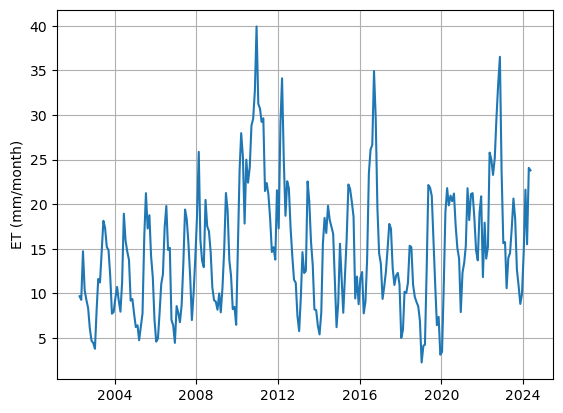

In [27]:
plt.plot(mid_months[1:], nw_monthly_et[1:])
plt.ylabel('ET (mm/month)')
plt.grid()
plt.imshow;

In [28]:
np.save('MODIS_ET/nw_modis_et_mean', nw_monthly_et)

## SOUTHEAST BASIN

In [29]:
# degree intervals
delta_lat = np.abs(np.diff(se_et.latitude.values).mean())
delta_lon = np.abs(np.diff(se_et.longitude.values).mean())

# latitude values
latitudes = se_et.latitude.values
colatitudes = 90 - latitudes  # Convert to colatitude

# convert to radians
dphi = np.deg2rad(delta_lon)
dtheta = np.deg2rad(delta_lat)
colat_rad = np.deg2rad(colatitudes)

# compute area weights for each latitude
area_weights_1d = (r**2) * np.sin(colat_rad) * dtheta * dphi  # shape: (lat,)
area_weights_2d = np.tile(area_weights_1d[:, np.newaxis], (1, se_et.longitude.size))

# convert to xarray
se_area_weights = xarray.DataArray(
    area_weights_2d,
    coords={"latitude": se_et.latitude, "longitude": se_et.longitude},
    dims=["latitude", "longitude"]
)




len_time = se_et.shape[0]
se_et_mean = np.zeros([len_time , 1])

for ii in range(len_time):
    
    aa = se_et[ii,:,:];
    if np.mod(ii , 100) == 0:
        print(str(ii)+'/'+str(len_time)+'...')
        
    masked_weights = se_area_weights.where(~np.isnan(aa))
    normalized_weights = masked_weights / masked_weights.sum(skipna=True)
    se_et_mean[ii] = (aa * normalized_weights).sum(skipna=True).values




# divide by 8 to get daily values
se_et_mean = se_et_mean/8

# get times
modis_times = se_et.time.values

# define daily times
daily_timesteps = np.arange('2002-02-19', '2024-05-25', dtype='datetime64[D]')

# define empty xarray
se_et_daily_mean = np.full(len(daily_timesteps ), np.nan)




for i in range(len(se_et_mean)):
    
    # get corresponding date
    modis_date = modis_times[i]

    # get the MODIS value for that date
    value = se_et_mean[i]
    
    # define the 8-day window ending at modis_date (i.e., modis_date - 7 days to modis_date)
    daily_dates = pd.date_range(modis_date - pd.Timedelta(days=7), modis_date, freq='D')
    
    # For each date in this 8-day window, assign the MODIS value (if date is in target range)
    for day in daily_dates:

        # Find index of this day in daily_dates
        idx = np.where(daily_timesteps == np.datetime64(day))[0]

        if idx.size > 0:
            se_et_daily_mean[idx[0]] = value




# create xarray
se_et_daily_mean = xarray.DataArray(
    se_et_daily_mean,
    coords={'time': daily_timesteps},
    dims='time',
    name='se_et_daily_mean'
)




# define dates in pd datetime format
dates = pd.to_datetime(daily_timesteps)

# build a list of "15th of month" dates from the range
mid_months = [t for t in dates if t.day == 15]

monthly_chunks = []

for mid_month in mid_months:

    # Define start as the 16th of previous month
    if mid_month.month == 1:
        start_month = 12
        start_year = mid_month.year - 1
    else:
        start_month = mid_month.month - 1
        start_year = mid_month.year

    period_start = datetime(start_year, start_month, 16)
    period_end = mid_month

    # Slice ET data for that time range
    daily_et_in_month = se_et_daily_mean.sel(time=slice(period_start, period_end))

    if daily_et_in_month.time.size > 0:
        total_et = daily_et_in_month.sum(dim='time', skipna=True)
        total_et = total_et.expand_dims(time=[mid_month])
        monthly_chunks.append(total_et)

# Combine into one DataArray
se_monthly_et = xarray.concat(monthly_chunks, dim='time')

0/1024...
100/1024...
200/1024...
300/1024...
400/1024...
500/1024...
600/1024...
700/1024...
800/1024...
900/1024...
1000/1024...


/var/folders/gb/ql94hjx53l9_bb657yf5p0880000gn/T/ipykernel_4765/226331403.py:83: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  se_et_daily_mean = xarray.DataArray(


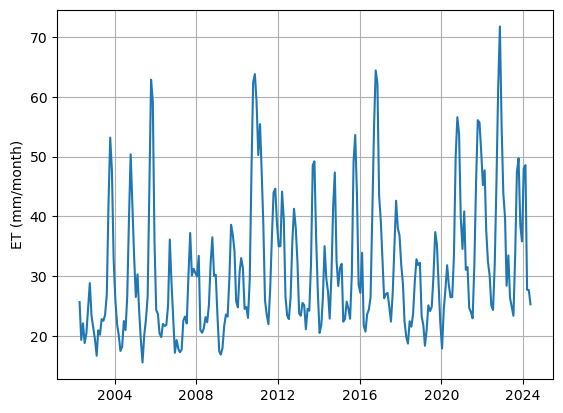

In [30]:
plt.plot(mid_months[1:], se_monthly_et[1:])
plt.ylabel('ET (mm/month)')
plt.grid()
plt.imshow;

In [31]:
np.save('MODIS_ET/se_modis_et_mean', se_monthly_et)

## SOUTHWEST BASIN

In [32]:
# degree intervals
delta_lat = np.abs(np.diff(sw_et.latitude.values).mean())
delta_lon = np.abs(np.diff(sw_et.longitude.values).mean())

# latitude values
latitudes = sw_et.latitude.values
colatitudes = 90 - latitudes  # Convert to colatitude

# convert to radians
dphi = np.deg2rad(delta_lon)
dtheta = np.deg2rad(delta_lat)
colat_rad = np.deg2rad(colatitudes)

# compute area weights for each latitude
area_weights_1d = (r**2) * np.sin(colat_rad) * dtheta * dphi  # shape: (lat,)
area_weights_2d = np.tile(area_weights_1d[:, np.newaxis], (1, sw_et.longitude.size))

# convert to xarray
sw_area_weights = xarray.DataArray(
    area_weights_2d,
    coords={"latitude": sw_et.latitude, "longitude": sw_et.longitude},
    dims=["latitude", "longitude"]
)




len_time = sw_et.shape[0]
sw_et_mean = np.zeros([len_time , 1])

for ii in range(len_time):
    
    aa = sw_et[ii,:,:];
    if np.mod(ii , 100) == 0:
        print(str(ii)+'/'+str(len_time)+'...')
        
    masked_weights = sw_area_weights.where(~np.isnan(aa))
    normalized_weights = masked_weights / masked_weights.sum(skipna=True)
    sw_et_mean[ii] = (aa * normalized_weights).sum(skipna=True).values




# divide by 8 to get daily values
sw_et_mean = sw_et_mean/8

# get times
modis_times = sw_et.time.values

# define daily times
daily_timesteps = np.arange('2002-02-19', '2024-05-25', dtype='datetime64[D]')

# define empty xarray
sw_et_daily_mean = np.full(len(daily_timesteps ), np.nan)




for i in range(len(sw_et_mean)):
    
    # get corresponding date
    modis_date = modis_times[i]

    # get the MODIS value for that date
    value = sw_et_mean[i]
    
    # define the 8-day window ending at modis_date (i.e., modis_date - 7 days to modis_date)
    daily_dates = pd.date_range(modis_date - pd.Timedelta(days=7), modis_date, freq='D')
    
    # For each date in this 8-day window, assign the MODIS value (if date is in target range)
    for day in daily_dates:

        # Find index of this day in daily_dates
        idx = np.where(daily_timesteps == np.datetime64(day))[0]

        if idx.size > 0:
            sw_et_daily_mean[idx[0]] = value




# create xarray
sw_et_daily_mean = xarray.DataArray(
    sw_et_daily_mean,
    coords={'time': daily_timesteps},
    dims='time',
    name='sw_et_daily_mean'
)




# define dates in pd datetime format
dates = pd.to_datetime(daily_timesteps)

# build a list of "15th of month" dates from the range
mid_months = [t for t in dates if t.day == 15]

monthly_chunks = []

for mid_month in mid_months:

    # Define start as the 16th of previous month
    if mid_month.month == 1:
        start_month = 12
        start_year = mid_month.year - 1
    else:
        start_month = mid_month.month - 1
        start_year = mid_month.year

    period_start = datetime(start_year, start_month, 16)
    period_end = mid_month

    # Slice ET data for that time range
    daily_et_in_month = sw_et_daily_mean.sel(time=slice(period_start, period_end))

    if daily_et_in_month.time.size > 0:
        total_et = daily_et_in_month.sum(dim='time', skipna=True)
        total_et = total_et.expand_dims(time=[mid_month])
        monthly_chunks.append(total_et)

# Combine into one DataArray
sw_monthly_et = xarray.concat(monthly_chunks, dim='time')

0/1024...
100/1024...
200/1024...
300/1024...
400/1024...
500/1024...
600/1024...
700/1024...
800/1024...
900/1024...
1000/1024...


/var/folders/gb/ql94hjx53l9_bb657yf5p0880000gn/T/ipykernel_4765/3769035368.py:83: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  sw_et_daily_mean = xarray.DataArray(


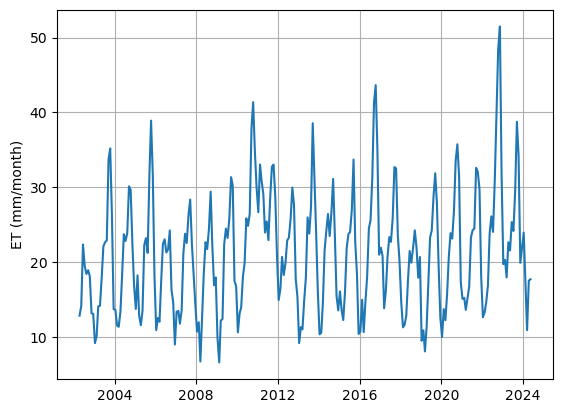

In [33]:
plt.plot(mid_months[1:], sw_monthly_et[1:])
plt.ylabel('ET (mm/month)')
plt.grid()
plt.imshow;

In [34]:
np.save('MODIS_ET/sw_modis_et_mean', sw_monthly_et)